In [9]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
from mne.stats import fdr_correction
% matplotlib inline

# R libraries for statistical models
% reload_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(effsize)

In [2]:
recall     = pd.read_csv('data/Recall.csv', sep = ',')
intrusions = pd.read_csv('data/Intrusions.csv', sep = ';')
emotion    = pd.read_csv('data/Emotion.csv', sep = ';')

# Test difference function

In [7]:
def test_diff(diff, threshold):
    '''
    Return statistics for a one sample t test corrected with fdr correction
    '''
    
    # P value
    A    = [ttest_1samp(diff[i,:],0).pvalue for i in range(1,1000)]
    A    = [1] + A # add 1 as first value (no comparisons)
    
    sig  = [i/100 for i in np.where(np.asarray(A) < threshold)]

    # Correct p value
    reject_fdr, pval_fdr = fdr_correction(A, alpha = threshold)
    fdr = []
    if True in reject_fdr :
        fdr = [i/100 for i in np.where(reject_fdr)]
        
    return sig, fdr, reject_fdr, pval_fdr

# Plot ecg

In [12]:
def plot_ecg(rt, ecg, pal, test, session, group):
    
    """
    Plot BPM evolution up to 10s after stim presentation
    
    Parameters
    ----------
        * rt       : Dataframe containing response times.
        * ecg      : List containing n list in the form [Array (BPM), String (Condition)].
        * pal      : Colors palette.
        * test     : Array. P values and corrected p values.
        * session  : String.
    """
    
    import warnings; warnings.simplefilter('ignore')

    plt.rcParams['figure.figsize'] = [8.0, 8.0]
    sns.set(context = 'notebook', style="ticks", palette=pal,font_scale=1.5)
    ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
    
    # First list
    ax1 = sns.tsplot(np.transpose(ecg[0][0][::20,:]), # Decimate to save memory
                     time = np.arange(0,10, 0.01), 
                     ci=[68],
                     linewidth= 3.0,
                     condition = ecg[0][1],
                     legend=False,
                     color=pal[0])
    
    # Second list
    ax1 = sns.tsplot(np.transpose(ecg[1][0][::20,:]), # Decimate to save memory
                     time = np.arange(0,10, 0.01), 
                     ci=[68],
                     linewidth= 3.0,
                     condition = ecg[1][1],
                     legend=False,
                     color=pal[1])
    
    if len(ecg)>2:
        # Third list
        ax1 = sns.tsplot(np.transpose(ecg[2][0][::20,:]), # Decimate to save memory
                         time = np.arange(0,10, 0.01), 
                         ci=[68],
                         linewidth= 3.0,
                         condition = ecg[2][1],
                         legend=False,
                         color=pal[2])
    ax1.set_xticks([])
    ax1.set_xlim([0,10])
    ax1.set_ylim([-5,3])
    ax1 = plt.ylabel('BPM', fontsize=25)
    
    # Plot statistic
    if test[0][0].size:
        plt.plot(sig, 2.5,'ko', alpha =.5)
    if test[1]:
        plt.plot(fdr, 2.5,'ro', alpha =.5)

    ax2 = plt.subplot2grid((5,1), (4,0))
    
    # Boxplot
    if session == 'Pre-test':
        factor = 'Emotion'
    else:
        factor = 'Condition'

    ax2 = sns.boxplot(x="RT", 
                      y=factor, 
                      data=rt,
                      notch = True,
                      linewidth=2.5,
                      palette=pal)
    ax2.set_xlim([0,10])
    ax2 = plt.xlabel('Time after onset (secs)', fontsize=25)
    ax2 = plt.ylabel('')
    ax2 = sns.despine()

# Group 1 

## Pre-test

In [5]:
# Load data
with open('data/ECG_Group1_Session1.txt', "rb") as fp:
   TOT2 = pickle.load(fp)
   
pre_sadnessTH, pre_sadnessNT, pre_sadnessBA, pre_disgustNT, pre_disgustBA, pre_disgustTH, pre_neutralTH, pre_neutralNT, pre_neutralBA = (np.ndarray(shape = (20000, len(TOT2))) for i in range(9))
for i_sub, sub in enumerate(TOT2):
    pre_neutralTH[:,i_sub] = sub[:,0]
    pre_neutralNT[:,i_sub] = sub[:,1]
    pre_neutralBA[:,i_sub] = sub[:,2]
    pre_disgustTH[:,i_sub] = sub[:,3]
    pre_disgustNT[:,i_sub] = sub[:,4]
    pre_disgustBA[:,i_sub] = sub[:,5]
    pre_sadnessTH[:,i_sub] = sub[:,6]
    pre_sadnessNT[:,i_sub] = sub[:,7]
    pre_sadnessBA[:,i_sub] = sub[:,8]
    
neutral = (pre_neutralTH + pre_neutralNT + pre_neutralBA)/3
disgust = (pre_disgustTH + pre_disgustNT + pre_disgustBA)/3
sadness = (pre_sadnessTH + pre_sadnessNT + pre_sadnessBA)/3

Test difference between neutral and emotion

In [10]:
diff = neutral - (disgust + sadness)/2
sig, fdr, pre_reject_fdr_emo, pval_fdr = test_diff(diff[::20], threshold = 0.05) # Decimate for speed

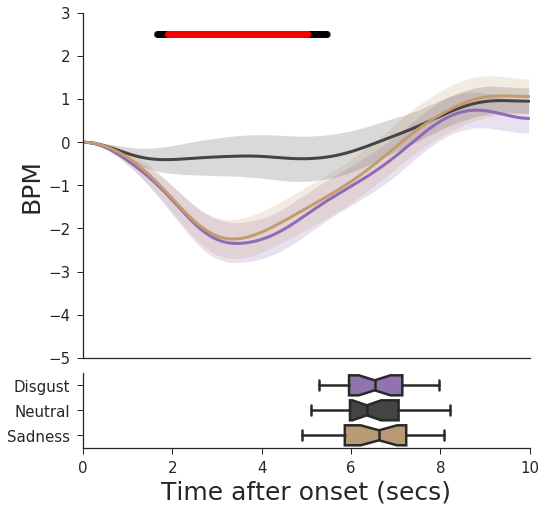

In [13]:
RT_df = emotion[(emotion.Group == 1) & (emotion.Session == 1)].groupby(['Subject', 'Emotion'], as_index=False).mean()
pal = ['#916ab7', '#444444', '#c49b6a'] # Disgust Neutral Sadness

plot_ecg(rt      = RT_df, 
         ecg     = [[disgust, 'Disgust'], [neutral, 'Neutral'], [sadness, 'Sadness']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Pre-test',
         group   = '1')

Time of interest (TOI)

In [62]:
print('From ' + str(np.where(pval_fdr<0.05)[0][0]/2000) + ' s to ' + str(np.where(pval_fdr<0.05)[0][-1]/2000) + 's.')

From 1.8815 s to 5.0335s.


Maximal deflection peak (MDP) and time of MDP for neutral

In [16]:
mdp   = neutral.mean(1).min()
t_mdp = neutral.mean(1).argmin()/2000

print('Maximum deflection peak is ' + str(mdp) + ' bpm occuring at t = ' + str(t_mdp) + ' seconds.')

Maximum deflection peak is -0.4037153804447918 bpm occuring at t = 1.8465 seconds.


Find larger difference and p values

In [28]:
min_sample    = ((disgust[::20].mean(1) + sadness[::20].mean(1))/2 - neutral[::20].mean(1)).argmin()
t_diff        = min_sample/2000
t_val         = ttest_1samp(diff[min_sample],0).statistic
pval_min      = pval_fdr[min_sample]
print('Larger difference at ' + str(t_diff) + ' seconds.')
print('T value is ' + str(t_val))
print('Corrected p value is ' + str(pval_min))

Larger difference at 0.1715 seconds.
T value is 0.39051811657067603
Corrected p value is 0.0016213874828552792


## Post-test

In [29]:
# Load data
with open('data/ECG_Group1_Session2.txt', "rb") as fp:
   TOT2 = pickle.load(fp)
   
post_sadnessTH, post_sadnessNT, post_sadnessBA, post_disgustNT, post_disgustBA, post_disgustTH, post_neutralTH, post_neutralNT, post_neutralBA = (np.ndarray(shape = (20000, len(TOT2))) for i in range(9))
for i_sub, sub in enumerate(TOT2):
    post_neutralTH[:,i_sub] = sub[:,0]
    post_neutralNT[:,i_sub] = sub[:,1]
    post_neutralBA[:,i_sub] = sub[:,2]
    post_disgustTH[:,i_sub] = sub[:,3]    
    post_disgustNT[:,i_sub] = sub[:,4]
    post_disgustBA[:,i_sub] = sub[:,5]
    post_sadnessTH[:,i_sub] = sub[:,6]    
    post_sadnessNT[:,i_sub] = sub[:,7]
    post_sadnessBA[:,i_sub] = sub[:,8]

## Average difference pre- post- TNT

### Disgust

Test difference between No-Think and Baseline

In [30]:
diff = post_disgustNT - post_disgustBA
sig, fdr, reject_fdr_suppr, pval_fdr = test_diff(diff[::20], threshold = 0.1)

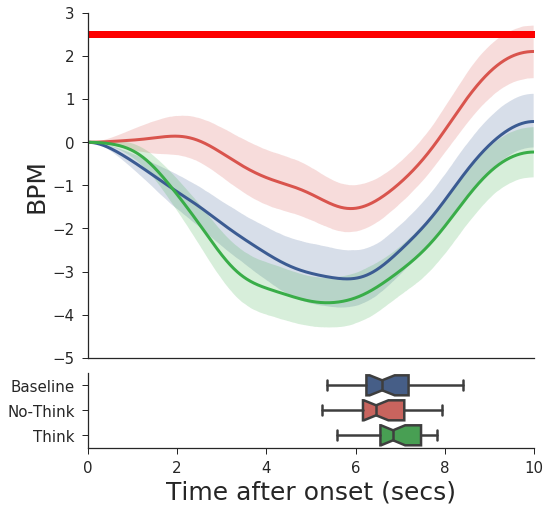

In [31]:
RT_df = emotion[(emotion.Emotion == 'Disgust') & (emotion.Group == 1) & (emotion.Session == 2)].groupby(['Subject', 'Condition'], as_index=False).mean()
pal   = ['#3b5b92', '#d9544d', '#39ad48'] # Baseline, No-Think, Think

plot_ecg(rt      = RT_df, 
         ecg     = [[post_disgustBA, 'Baseline'], [post_disgustNT, 'No-Think'], [post_disgustTH, 'Think']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Post-test',
         group   = '1_Disgust')

### Sadness

Test difference between No-Think and Baseline

In [32]:
diff = post_sadnessNT - post_sadnessBA
sig, fdr, reject_fdr_suppr, pval_fdr = test_diff(diff[::20], threshold = 0.1)

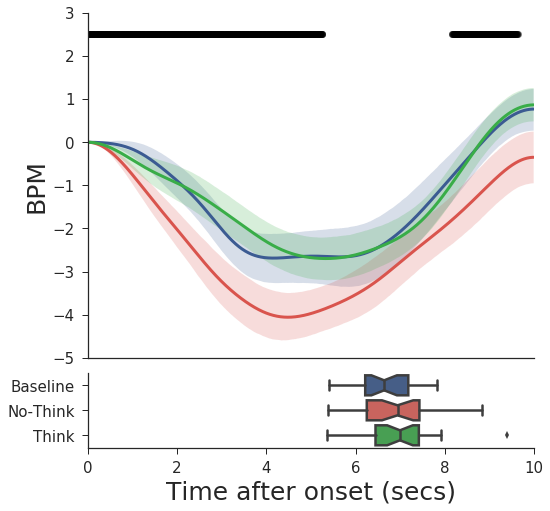

In [33]:
RT_df = emotion[(emotion.Emotion == 'Sadness') & (emotion.Group == 1) & (emotion.Session == 2)].groupby(['Subject', 'Condition'], as_index=False).mean()
pal   = ['#3b5b92', '#d9544d', '#39ad48'] # Baseline, No-Think, Think

plot_ecg(rt      = RT_df, 
         ecg     = [[post_sadnessBA, 'Baseline'], [post_sadnessNT, 'No-Think'], [post_sadnessTH, 'Think']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Post-test',
         group   = '1_Sadness')

### Neutral

Test difference between No-Think and Baseline

In [34]:
diff = post_neutralNT - post_neutralBA
sig, fdr, reject_fdr_suppr, pval_fdr = test_diff(diff[::20], threshold = 0.1)

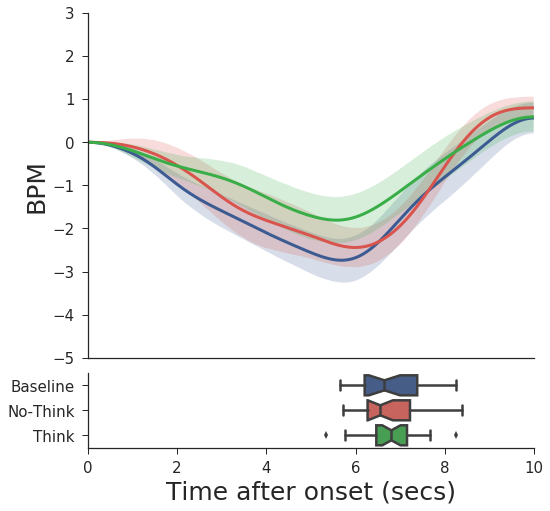

In [35]:
RT_df = emotion[(emotion.Emotion == 'Neutral') & (emotion.Group == 1) & (emotion.Session == 2)].groupby(['Subject', 'Condition'], as_index=False).mean()
pal   = ['#3b5b92', '#d9544d', '#39ad48'] # Baseline, No-Think, Think

plot_ecg(rt      = RT_df, 
         ecg     = [[post_neutralBA, 'Baseline'], [post_neutralNT, 'No-Think'], [post_neutralTH, 'Think']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Post-test',
         group   = '1_Neutral')

# Barplot

# Group 1

In [55]:
mean_neutral = (post_neutralTH + post_neutralNT + post_neutralBA)/3

# Extract mean bpm over the TOI (pre_reject_fdr_emo)
plot_sadnessTH = post_sadnessTH[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_sadnessNT = post_sadnessNT[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_sadnessBA = post_sadnessBA[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_disgustTH = post_disgustTH[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_disgustNT = post_disgustNT[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_disgustBA = post_disgustBA[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)

# Create a df in a long format
plot = np.array([plot_sadnessTH, plot_sadnessNT, plot_sadnessBA, 
                 plot_disgustTH, plot_disgustNT, plot_disgustBA])

header = pd.MultiIndex.from_product([['Sadness','Disgust'],
                                     ['Think', 'No-Think', 'Baseline']],
                                     names=['Emotion','Condition'])
data = pd.DataFrame(np.transpose(plot), columns= header).stack(level=[0, 1]).reset_index()
data = data.rename(index=str, columns={"level_0": "Subject", 0: "bpm"})

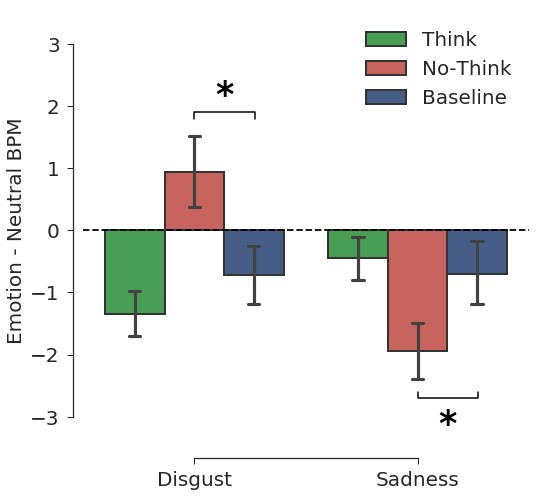

In [56]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(context = 'notebook', font_scale=2, style="ticks")

plt.axhline(y=0, color = 'black', linestyle='--')    

sns.barplot(data=data, 
            x = "Emotion", 
            y = "bpm",
            hue = "Condition", 
            linewidth=2.,
            dodge=True,
            hue_order=['Think', 'No-Think', 'Baseline'], 
            capsize=.05,
            ci=68,
            palette = ['#39ad48', '#d9544d', '#3b5b92'],
            edgecolor = [".2", ".2"])

plt.legend(fontsize = 20,
           ncol=1)

plt.ylabel('Emotion - Neutral BPM', fontsize=20)
plt.xlabel('')

# statistical annotation 1
x1, x2 = 0, 0.27   # columns NT and BA
y = 1.9
plt.plot([x1, x1, x2, x2], [y-0.1, y, y, y-0.1], lw=1.5, c='k')
plt.text((x1+x2)*.5, y, "*", 
         ha='center', 
         va='bottom', 
         color='k',
         weight = 'bold',
         fontsize=35)

# statistical annotation 2
x1, x2 = 1, 1.27   # columns NT and BA
y = -2.7
plt.plot([x1, x1, x2, x2], [y+0.1, y, y, y+0.1], lw=1.5, c='k')
plt.text((x1+x2)*.5, y-0.7, "*", 
         ha='center', 
         va='bottom', 
         color='k',
         weight = 'bold',
         fontsize=35)

plt.ylim([-3.5, 3.5])
sns.despine(offset=10, trim=True)

In [83]:
%%R -i data

stats = aov_ez(data,                           
               id="Subject",                     
               dv="bpm",                         
               within=c("Emotion", "Condition"))
stats

Anova Table (Type 3 tests)

Response: X0
             Effect          df  MSE         F  ges p.value
1           Emotion       1, 27 5.86    3.03 +  .02     .09
2         Condition 1.95, 52.53 7.65      0.29 .004     .75
3 Emotion:Condition 1.94, 52.50 3.85 14.76 ***  .10  <.0001
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


In [58]:
# Split participants according to their score at recall
NT = recall.Recall[(recall.Group == 1) & (recall.Emotion == 'Disgust') & (recall.Condition == 'No-Think')]
Dis_for = np.asarray(NT) < 100

NT = recall.Recall[(recall.Group == 1) & (recall.Emotion == 'Sadness') & (recall.Condition == 'No-Think')]
Sad_for = np.asarray(NT) < 100

# Disgust - Forgetting present
plot_disgustNT = post_disgustNT[::20][pre_reject_fdr_emo].mean(0)[Dis_for] - mean_neutral[::20][pre_reject_fdr_emo].mean(0)[Dis_for]
dis_high_for = plot_disgustNT 

# Disgust - Forgetting absent
plot_disgustNT = post_disgustNT[::20][pre_reject_fdr_emo].mean(0)[~Dis_for] - mean_neutral[::20][pre_reject_fdr_emo].mean(0)[~Dis_for]
dis_low_for = plot_disgustNT 

# Sadness - Forgetting present
plot_sadnessNT = post_sadnessNT[::20][pre_reject_fdr_emo].mean(0)[Sad_for] - mean_neutral[::20][pre_reject_fdr_emo].mean(0)[Sad_for]
sad_high_for = plot_sadnessNT

# Sadness - Forgetting absent
plot_sadnessNT = post_sadnessNT[::20][pre_reject_fdr_emo].mean(0)[~Sad_for] - mean_neutral[::20][pre_reject_fdr_emo].mean(0)[~Sad_for]
sad_low_for = plot_sadnessNT

# Create df
output_df = pd.DataFrame([])
for i in range(len(dis_high_for)):    
    output_df = output_df.append(pd.DataFrame({'BPM' : dis_high_for[i],
                                               'Emotion': 'Disgust',
                                               'Forgetting':'Present'}, index=[0]), ignore_index=True)
    
for i in range(len(dis_low_for)):    
    output_df = output_df.append(pd.DataFrame({'BPM' : dis_low_for[i],
                                               'Emotion': 'Disgust',
                                               'Forgetting':'Absent'}, index=[0]), ignore_index=True)
    
for i in range(len(sad_high_for)):    
    output_df = output_df.append(pd.DataFrame({'BPM' : sad_high_for[i],
                                               'Emotion': 'Sadness',
                                               'Forgetting':'Present'}, index=[0]), ignore_index=True)
    
for i in range(len(sad_low_for)):    
    output_df = output_df.append(pd.DataFrame({'BPM' : sad_low_for[i],
                                               'Emotion': 'Sadness',
                                               'Forgetting':'Absent'}, index=[0]), ignore_index=True)

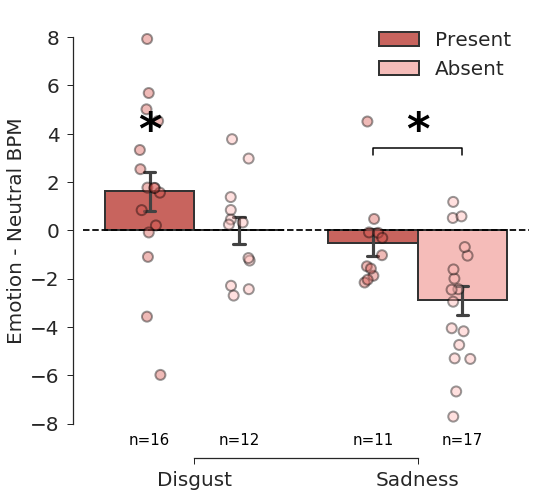

In [59]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.axhline(y=0, color = 'black', linestyle='--')    
ax = sns.barplot(data = output_df,
        x = 'Emotion',
        y = 'BPM',
        hue = 'Forgetting',
        linewidth=2.,
        capsize=.05,
        ci=68,
        edgecolor = [".2", ".2"],
        palette = ['#d9544d', '#ffb3af'])

sns.stripplot(data = output_df,
        x = 'Emotion',
        y = 'BPM',
        hue = 'Forgetting',
        alpha = 0.4,
        dodge = True,
        edgecolor = 'k',
        size  =10,
        jitter = True,
        linewidth=2,
        palette = ['#d9544d', '#ffb3af'])
plt.xlabel('')
plt.ylabel('Emotion - Neutral BPM', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], 
           fontsize = 20,
           ncol=1)

# statistical annotation 1
x1, x2 = 0, 0.27   # columns NT and BA
y = 1.9
plt.text(-0.2, 3.2, "*", 
         ha='center', 
         va='bottom', 
         color='k',
         weight = 'bold',
         fontsize=45)

# statistical annotation 2
x1, x2 = 0.8, 1.2   # columns NT and BA
y = 3.4
plt.plot([x1, x1, x2, x2], [y-0.3, y, y, y-0.3], lw=1.5, c='k')
plt.text(1, 3.2, "*", 
         ha='center', 
         va='bottom', 
         color='k',
         weight = 'bold',
         fontsize=45)
# Ns
plt.text(-.2, -9, "n=16", 
         ha='center', 
         va='bottom', 
         color='k',
         fontsize=15)

plt.text(.2, -9, "n=12", 
         ha='center', 
         va='bottom', 
         color='k',
         fontsize=15)

plt.text(.8, -9, "n=11", 
         ha='center', 
         va='bottom', 
         color='k',
         fontsize=15)

plt.text(1.2, -9, "n=17", 
         ha='center', 
         va='bottom', 
         color='k',
         fontsize=15)

plt.ylim([-9, 9])

sns.despine(offset=10, trim=True)

# Group 2

## Pre-test

In [60]:
# Load data
with open('data/ECG_Group2_Session1.txt', "rb") as fp:
   TOT2 = pickle.load(fp)
   
pre_sadnessTH, pre_sadnessNT, pre_sadnessBA, pre_disgustNT, pre_disgustBA, pre_disgustTH, pre_neutralTH, pre_neutralNT, pre_neutralBA = (np.ndarray(shape = (20000, len(TOT2))) for i in range(9))
for i_sub, sub in enumerate(TOT2):
    pre_neutralTH[:,i_sub] = sub[:,0]
    pre_neutralNT[:,i_sub] = sub[:,1]
    pre_neutralBA[:,i_sub] = sub[:,2]
    pre_disgustTH[:,i_sub] = sub[:,3]    
    pre_disgustNT[:,i_sub] = sub[:,4]
    pre_disgustBA[:,i_sub] = sub[:,5]
        
neutral = (pre_neutralTH + pre_neutralNT + pre_neutralBA)/3
disgust = (pre_disgustTH + pre_disgustNT + pre_disgustBA)/3

Test difference between neutral and emotions

In [61]:
diff = neutral - disgust
sig, fdr, pre_reject_fdr_emo, pval_fdr = test_diff(diff[::20], threshold = 0.05)

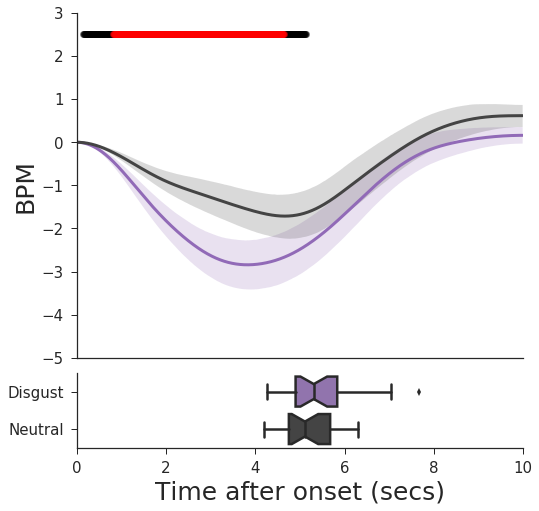

In [62]:
RT_df = emotion[(emotion.Group == 2) & (emotion.Session == 1)].groupby(['Subject', 'Emotion'], as_index=False).mean()
pal = ['#916ab7', '#444444'] # Disgust Neutral

plot_ecg(rt      = RT_df, 
         ecg     = [[disgust, 'Disgust'], [neutral, 'Neutral']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Pre-test',
         group   = '2')

## Post-test

In [64]:
# Import ECG data
with open('data/ECG_Group2_Session2.txt', "rb") as fp:
   TOT2 = pickle.load(fp)
   
post_sadnessTH, post_sadnessNT, post_sadnessBA, post_disgustNT, post_disgustBA, post_disgustTH, post_neutralTH, post_neutralNT, post_neutralBA = (np.ndarray(shape = (20000, len(TOT2))) for i in range(9))
for i_sub, sub in enumerate(TOT2):
    post_neutralTH[:,i_sub] = sub[:,0]
    post_neutralNT[:,i_sub] = sub[:,1]
    post_neutralBA[:,i_sub] = sub[:,2]
    post_disgustTH[:,i_sub] = sub[:,3]
    post_disgustNT[:,i_sub] = sub[:,4]
    post_disgustBA[:,i_sub] = sub[:,5]

### Disgust

Test difference between No-Think and Baseline

In [49]:
diff = post_disgustNT - post_disgustBA
sig, fdr, reject_fdr_suppr, pval_fdr = test_diff(diff[::20], threshold = 0.1)

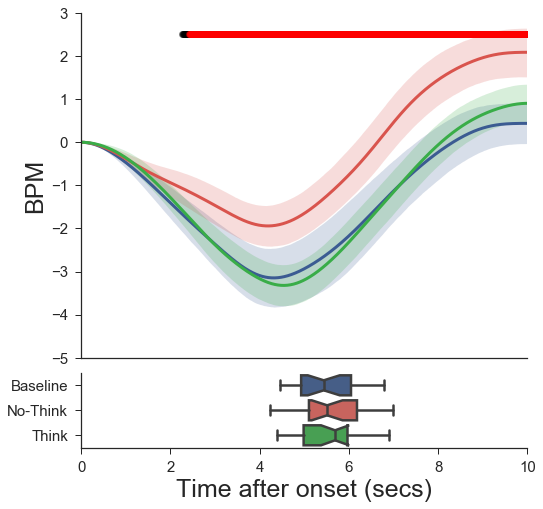

In [50]:
RT_df = emotion[(emotion.Emotion == 'Disgust') & (emotion.Group == 2) & (emotion.Session == 2)].groupby(['Subject', 'Condition'], as_index=False).mean()
pal   = ['#3b5b92', '#d9544d', '#39ad48'] # Baseline, No-Think, Think

plot_ecg(rt      = RT_df, 
         ecg     = [[post_disgustBA, 'Baseline'], [post_disgustNT, 'No-Think'], [post_disgustTH, 'Think']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Post-test_Disgust',
         group   = '2')

### Neutral

Compute statistics

In [51]:
diff = post_neutralNT - post_neutralBA
sig, fdr, reject_fdr_suppr_neu, pval_fdr = test_diff(diff[::20], threshold = 0.1)

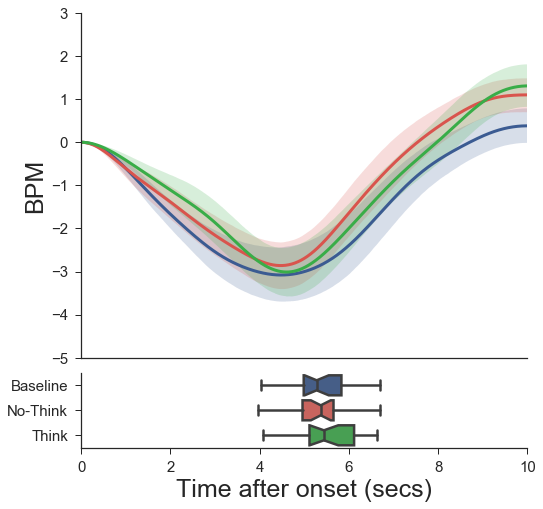

In [52]:
RT_df = emotion[(emotion.Emotion == 'Neutral') & (emotion.Group == 2) & (emotion.Session == 2)].groupby(['Subject', 'Condition'], as_index=False).mean()
pal   = ['#3b5b92', '#d9544d', '#39ad48'] # Baseline, No-Think, Think

plot_ecg(rt      = RT_df, 
         ecg     = [[post_neutralBA, 'Baseline'], [post_neutralNT, 'No-Think'], [post_neutralTH, 'Think']],
         pal     = pal,
         test    = [sig, fdr],
         session = 'Post-test_Neutral',
         group   = '2')

# Barplot

In [65]:
mean_neutral = (post_neutralTH + post_neutralNT + post_neutralBA)/3

plot_disgustTH = post_disgustTH[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_disgustNT = post_disgustNT[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)
plot_disgustBA = post_disgustBA[::20][pre_reject_fdr_emo].mean(0) - mean_neutral[::20][pre_reject_fdr_emo].mean(0)

plot = np.array([plot_disgustTH, plot_disgustNT, plot_disgustBA])

data = pd.DataFrame(np.transpose(plot), columns= ['Think', 'No-Think', 'Baseline'])
data['Subject'] = recall[recall.Group == 2].Subject.unique()
data = data.melt(id_vars= ['Subject'])

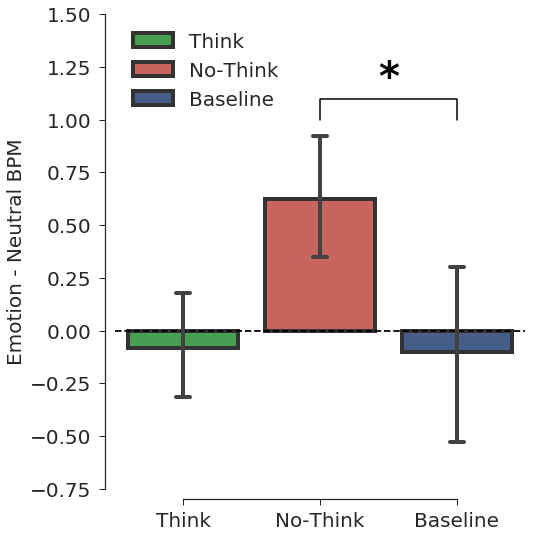

In [67]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(context = 'notebook', font_scale=2, style="ticks")

plt.axhline(y=0, color = 'black', linestyle='--')    

sns.barplot(data=data, 
            x = "variable", 
            y = 'value',
            hue = "variable",
            dodge=False,
            linewidth=4.,
            capsize=.1,
            ci=68,
            errwidth = 4,
            palette = ['#39ad48', '#d9544d', '#3b5b92'],
            edgecolor = [".2", ".2"])

plt.ylabel('Emotion - Neutral BPM', fontsize=20)
plt.xlabel('')

# statistical annotation 1
x1, x2 = 1, 2   # columns NT and BA
y = 1.1
plt.plot([x1, x1, x2, x2], [y-0.1, y, y, y-0.1], lw=1.5, c='k')
plt.text((x1+x2)*.5, y, "*", 
         ha='center', 
         va='bottom', 
         color='k', 
         weight = 'bold',
         fontsize=40)

plt.ylim([-0.75, 1.5])
plt.legend(title = '', loc = 2)
sns.despine(offset=10, trim=True)

plt.tight_layout()

In [106]:
%%R -i data

stats = aov_ez(data,                           
               id="Subject",                     
               dv="value",                         
               within=c("variable"))
stats

Anova Table (Type 3 tests)

Response: value
    Effect          df  MSE      F ges p.value
1 variable 1.97, 45.39 1.43 2.92 + .04     .07
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 
